In [175]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import seaborn as sns

flag_paths = {
    "CN": "../docs/flags/br.png",
    "USA": "../docs/flags/usa.png",
    "ID": "../docs/flags/br.png",
    "IN": "../docs/flags/br.png",
    "GB": "../docs/flags/gb.png",
    "DE": "../docs/flags/br.png",
    "JP": "../docs/flags/br.png",
    "RU": "../docs/flags/br.png",
    "CA": "../docs/flags/br.png",
    "FR": "../docs/flags/br.png",
    "KR": "../docs/flags/br.png",
    "BR": "../docs/flags/br.png",
    "IT": "../docs/flags/br.png",
    "ES": "../docs/flags/br.png",
    "AU": "../docs/flags/br.png",
}


def plot_bar_chart_countries_with_flags(
    df: pd.DataFrame, flag_paths: dict
) -> plt.Figure:
    # Ensure the 'count' column is numeric
    df["count"] = pd.to_numeric(df["count"], errors="coerce")

    # Sort countries by count and add a ranking column
    df = df.sort_values("count", ascending=False).reset_index(drop=True)
    df["rank"] = df.index + 1

    # Create the figure and axis
    fig, ax = plt.subplots(figsize=(10, 6))

    # Create the bar plot
    sns.barplot(
        x="name",
        y="count",
        data=df,
        ax=ax,
    )

    # Annotate each bar with "XK" (thousands) on top of the bar
    for i, p in enumerate(ax.patches):
        height = p.get_height()
        count_in_k = f"{height/1000:.0f}K"  # e.g., 456362 -> "456K"

        ax.annotate(
            count_in_k,
            (p.get_x() + p.get_width() / 2, height),
            ha="center",
            va="bottom",
            fontsize=10,
            color="black",
        )

    # Remove default x-ticks and x-axis label
    ax.set_xticks([])
    ax.set_xlabel("")

    # Remove y-axis ticks (since we show counts on the bars)
    ax.set_yticks([])
    ax.set_ylabel("")

    # --- Custom code to place flags + country names on the x-axis ---
    # Increase bottom margin so we have space for flags and text
    plt.subplots_adjust(bottom=0.50)

    for i, row in df.iterrows():
        country = row["name"]
        rank = row["rank"]

        # 1. Add the country name (with rank) below the x-axis
        #    Using transform=ax.get_xaxis_transform() places text relative to the x-axis
        #    y = -0.02 puts the text slightly below the axis line
        ax.text(
            i,
            -0.02,
            f"{rank}. {country}",
            transform=ax.get_xaxis_transform(),
            ha="center",
            va="top",
            # fontsize=8,
        )

        # 2. Place the flag above the country name
        if country in flag_paths:
            try:
                flag_img = mpimg.imread(flag_paths[country])
                imagebox = OffsetImage(flag_img, zoom=0.3)  # Adjust zoom as needed

                # We create an AnnotationBbox, anchoring its bottom to the y=-0.02 (same as text)
                # then shift it upward by a few points (xybox=(0, 0) -> no shift).
                ab = AnnotationBbox(
                    imagebox,
                    (i, -0.02),  # (x, y) in data coords
                    xycoords=ax.get_xaxis_transform(),
                    boxcoords="offset points",
                    xybox=(0, -35),  # shift upward in points if needed
                    box_alignment=(
                        0.5,
                        0,
                    ),  # center horizontally, bottom edge aligned to y
                    frameon=False,
                )
                ax.add_artist(ab)
            except Exception as e:
                print(f"Could not load flag for {country}: {e}")
    # -----------------------------------------------------------------

    # Set the title
    ax.set_title("Number of Publications by Country", fontsize=14)

    plt.tight_layout()
    return fig


def plot_publication_percentages_by_country(df):
    """
    Reads the aggregated publication counts CSV and creates a line plot for each country.
    For each country, it computes the percentage of publications per subfield (i.e.,
    number of publications of a subfield divided by the total publications for that year)
    for the top 5 subfields, and plots these percentages over the years 2019 to 2024.
    A common legend is displayed at the bottom.
    """
    # Load the CSV file and ensure publication_year is integer
    df["publication_year"] = df["publication_year"].astype(int)

    # Get unique country codes
    countries = df["country_code"].unique()

    # Setup seaborn theme for better visuals
    sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)

    # Create a subplot grid: here we assume 4 countries and use a 2x2 grid (adjust as needed)
    n_countries = len(countries)
    n_rows = (n_countries + 1) // 2
    fig, axes = plt.subplots(
        n_rows, 2, figsize=(15, 5 * n_rows), sharex=True, sharey=True
    )
    axes = axes.flatten()

    # Dictionary to collect legend entries across subplots
    legend_entries = {}

    for i, country in enumerate(countries):
        ax = axes[i]
        # Filter data for the current country and work on a copy
        df_country = df[df["country_code"] == country].copy()

        # Compute the total publications per year for this country
        total_per_year = (
            df_country.groupby("publication_year")["count"]
            .sum()
            .reset_index(name="total")
        )
        df_country = df_country.merge(total_per_year, on="publication_year")

        # Calculate the percentage of publications for each subfield per year
        df_country["percentage"] = (df_country["count"] / df_country["total"]) * 100

        # Determine top 5 subfields (by total count over the period for that country)
        subfield_totals = (
            df_country.groupby("subfield_display_name")["count"].sum().reset_index()
        )
        top5 = subfield_totals.nlargest(5, "count")["subfield_display_name"].tolist()

        # Filter to only include rows for these top subfields
        df_top = df_country[df_country["subfield_display_name"].isin(top5)]

        # Create the line plot for percentages by publication year for the top subfields
        lineplot = sns.lineplot(
            data=df_top,
            x="publication_year",
            y="percentage",
            hue="subfield_display_name",
            style="subfield_display_name",
            markers=True,
            markersize=8,
            dashes=False,
            ax=ax,
            linewidth=1.5,
        )
        ax.set_title(f"Country: {country}")
        ax.set_xlabel("Publication Year")
        ax.set_ylabel("Percentage (%)")

        # Remove individual legends from subplots
        ax.get_legend().remove()

        # Collect legend handles and labels from the first subplot (assuming consistency across plots)
        if i == 0:
            handles, labels = lineplot.get_legend_handles_labels()
            for h, l in zip(handles, labels):
                legend_entries[l] = h

    # Hide any unused subplots if number of countries is less than the grid size
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    # Create a common legend from the collected legend entries
    common_handles = list(legend_entries.values())
    common_labels = list(legend_entries.keys())
    fig.legend(
        common_handles,
        common_labels,
        loc="lower center",
        ncol=5,
        bbox_to_anchor=(0.5, 0.01),
    )

    fig.suptitle(
        "Percentage of Publications per Subfield by Country (2019 - 2024)",
        fontsize=16,
        y=0.925,
    )
    fig.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.savefig(
        "../docs/publication_percentages_by_country.pdf",
        format="pdf",
        bbox_inches="tight",
    )

    return fig


def plot_avg_citations_by_country(df):
    """
    Reads the aggregated publication counts CSV (for Brazil) and creates a line plot for each country.
    For each country, it computes the average citations per publication for each subfield per year
    (i.e., citation_count / count) for the top 5 subfields (by total publication count)
    and plots these average citations over the years 2019 to 2024.
    A common legend is displayed at the bottom.
    """
    # Ensure publication_year is integer
    df["publication_year"] = df["publication_year"].astype(int)

    # Compute average citations per publication for each row
    df["avg_citations"] = df["citation_count"] / df["count"]

    # Get unique country codes (should be one, but keeping the structure for consistency)
    countries = df["country_code"].unique()

    # Setup seaborn theme for better visuals
    sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)

    # Create a subplot grid: here we assume 4 countries and use a 2x2 grid (adjust as needed)
    n_countries = len(countries)
    n_rows = (n_countries + 1) // 2
    fig, axes = plt.subplots(
        n_rows, 2, figsize=(15, 5 * n_rows), sharex=True, sharey=True
    )
    axes = axes.flatten()

    # Dictionary to collect legend entries across subplots
    legend_entries = {}

    for i, country in enumerate(countries):
        ax = axes[i]
        # Filter data for the current country and work on a copy
        df_country = df[df["country_code"] == country].copy()

        # Determine top 5 subfields (by total publication count over the period for that country)
        subfield_totals = (
            df_country.groupby("subfield_display_name")["count"].sum().reset_index()
        )
        top5 = subfield_totals.nlargest(5, "count")["subfield_display_name"].tolist()

        # Filter to only include rows for these top subfields
        df_top = df_country[df_country["subfield_display_name"].isin(top5)]

        # Create the line plot for average citations per publication by publication year for the top subfields
        lineplot = sns.lineplot(
            data=df_top,
            x="publication_year",
            y="avg_citations",
            hue="subfield_display_name",
            style="subfield_display_name",
            markers=True,
            markersize=8,
            dashes=False,
            ax=ax,
            linewidth=1.5,
        )
        ax.set_title(f"Country: {country}")
        ax.set_xlabel("Publication Year")
        ax.set_ylabel("Average Citations")

        # Remove individual legends from subplots
        ax.get_legend().remove()

        # Collect legend handles and labels from the first subplot (assuming consistency across plots)
        if i == 0:
            handles, labels = lineplot.get_legend_handles_labels()
            for h, l in zip(handles, labels):
                legend_entries[l] = h

    # Hide any unused subplots if number of countries is less than the grid size
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    # Create a common legend from the collected legend entries
    common_handles = list(legend_entries.values())
    common_labels = list(legend_entries.keys())
    fig.legend(
        common_handles,
        common_labels,
        loc="lower center",
        ncol=5,
        bbox_to_anchor=(0.5, 0.01),
    )

    fig.suptitle(
        "Average Citations per Publication by Subfield (2019 - 2024)",
        fontsize=16,
        y=0.93,
    )
    fig.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.savefig(
        "../docs/avg_citations_by_country.pdf", format="pdf", bbox_inches="tight"
    )

    return fig

In [176]:
# df_publication_counts = pd.read_csv(
#     "../data/csv/_counts/combined_publication_counts.csv"
# )

In [177]:
# plot_publication_percentages_by_country(df_publication_counts)
# plt.show()

In [178]:
# plot_avg_citations_by_country(df_publication_counts)
# plt.show()

In [179]:
countries_df = pd.read_csv("../data/csv/openalex-top-countries.csv")

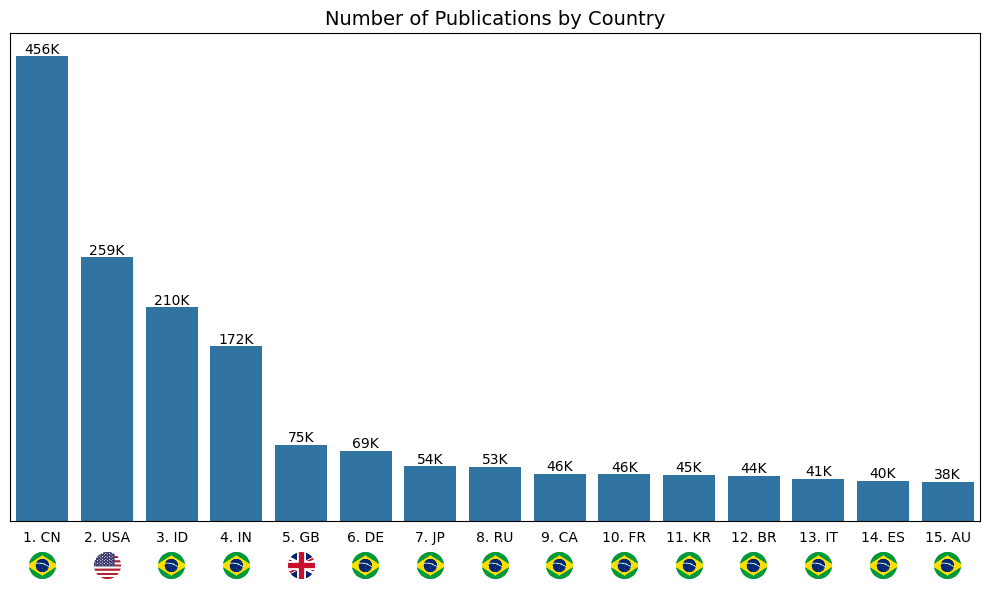

In [180]:
plot_bar_chart_countries_with_flags(countries_df, flag_paths)
plt.show()